## Phrase-level frequency count of SAR words in PR title, body, and comments

In [5]:
import pandas as pd
import re
from collections import defaultdict, Counter
import pandas as pd
import numpy as np
import sys
import os

if "__file__" in globals():
    script_dir = os.path.dirname(os.path.abspath(__file__))
else:
    script_dir = os.getcwd() 

# Path to parent/Data Analysis
data_analysis_path = os.path.abspath(os.path.join(script_dir, "..", "Data Analysis"))
data_analysis_path = os.path.abspath(data_analysis_path)

sys.path.append(data_analysis_path)

import bug_fix_list
import internal_list
import external_list
import functional_list
import code_smell_list

bug_words = bug_fix_list.bug_words
internal_words = internal_list.internal_words
external_words = external_list.external_words
functional_words = functional_list.functional_words
smell_words = code_smell_list.smell_words

In [6]:
print('Starting script.')
pull_request_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pull_request.parquet")
comments_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_comments.parquet")
pr_task_type_df = pd.read_parquet("hf://datasets/hao-li/AIDev/pr_task_type.parquet")
print('Finished querying parquets.')
pull_request_df.rename(columns={'id': 'pr_id'}, inplace=True)

Starting script.


ImportError: Install huggingface_hub to access HfFileSystem

In [3]:
# need body from pr_comments
combined_df = pull_request_df.merge(
    comments_df[['id', 'body']].add_prefix('comment_'),
    how='left',
    left_on='pr_id',
    right_on='comment_id',
    suffixes=('', '_task')
)
combined_df.drop(columns=['comment_id'])

# only look at refactor
combined_df = combined_df.merge(
    pr_task_type_df[['id', 'type']],
    how='left',
    left_on='pr_id',
    right_on='id'
)
combined_df.rename(columns={'type': 'pr_type'}, inplace=True)
combined_df = combined_df.loc[combined_df['pr_type'].str.contains('refactor', na=False)].copy()


print(f"Length of combined_df: {len(combined_df)}")
# print(combined_df)

Length of combined_df: 2288


In [84]:
print("Counting SAR phrase occurrences...")

def to_regex_pattern(word):
    return re.escape(word).replace(r'\*', '.*')

for phrase in bug_words:
    pattern = re.compile(to_regex_pattern(phrase), re.IGNORECASE)
    combined_df[phrase] = (
        combined_df['body'].str.contains(pattern, na=False) |
        combined_df['comment_body'].str.contains(pattern, na=False) |
        combined_df['title'].str.contains(pattern, na=False)
    )

for phrase in internal_words:
    pattern = re.compile(to_regex_pattern(phrase), re.IGNORECASE)
    combined_df[phrase] = (
        combined_df['body'].str.contains(pattern, na=False) |
        combined_df['comment_body'].str.contains(pattern, na=False) |
        combined_df['title'].str.contains(pattern, na=False)
    )

for phrase in external_words:
    pattern = re.compile(to_regex_pattern(phrase), re.IGNORECASE)
    combined_df[phrase] = (
        combined_df['body'].str.contains(pattern, na=False) |
        combined_df['comment_body'].str.contains(pattern, na=False) |
        combined_df['title'].str.contains(pattern, na=False)
    )

for phrase in functional_words:
    pattern = re.compile(to_regex_pattern(phrase), re.IGNORECASE)
    combined_df[phrase] = (
        combined_df['body'].str.contains(pattern, na=False) |
        combined_df['comment_body'].str.contains(pattern, na=False) |
        combined_df['title'].str.contains(pattern, na=False)
    )

for phrase in smell_words:
    pattern = re.compile(to_regex_pattern(phrase), re.IGNORECASE)
    combined_df[phrase] = (
        combined_df['body'].str.contains(pattern, na=False) |
        combined_df['comment_body'].str.contains(pattern, na=False) |
        combined_df['title'].str.contains(pattern, na=False)
    )

unique_prs = combined_df.drop_duplicates(subset=['pr_id'])

freq_count = defaultdict(lambda: defaultdict(int))

phrase_lists = [bug_words, internal_words, external_words, functional_words, smell_words]

# To avoid KeyErrors later, prefill counts
agents = unique_prs["agent"].unique()
for agent in agents:
    for list in phrase_lists:
        for phrase in list:
            freq_count[agent][phrase] = 0

for idx, row in unique_prs.iterrows():
    agent = row["agent"]
    for list in phrase_lists:
        found_any = False
        for phrase in list:
            if row[phrase]:
                if not found_any:
                    freq_count[agent][phrase] += 1
                    found_any = True

# Convert dict to DataFrame
summary_df = pd.DataFrame([
    {"agent": agent, **counts}
    for agent, counts in freq_count.items()
])
print(summary_df)

# Save output
output_path = "sar_rq1_phrase_frequency_table.csv"
summary_df.to_csv(output_path)
print(f"Saved table: {output_path}")

Counting SAR phrase occurrences...
          agent  Minor fixes  Get rid of  Additional fixes  Handle  \
0   Claude_Code            0           0                 0       2   
1       Copilot            0           0                 0      74   
2  OpenAI_Codex            0           0                 0      79   
3        Cursor            0           1                 0      12   
4         Devin            0           0                 0      71   

   Decoupling  Reduce complexity  Chang* inheritance  Better encapsulation  \
0           0                  0                   0                     0   
1           7                  1                   1                     1   
2           0                  0                   0                     0   
3           0                  0                   0                     0   
4           0                  1                   1                     0   

   Remov* dependency  ...  UI changes  Avoid code duplication  \
0         

### Calculations

In [128]:
percent_sar_df = summary_df[["agent"]].copy()

# Count total PRs for each agent
pr_counts = unique_prs.groupby("agent")["pr_id"].nunique()
percent_sar_df["Total PRs"] = summary_df["agent"].map(pr_counts)

# Count PRs with SAR for each agent
total_requests = (
    unique_prs
    .groupby(['agent', 'is_sar'])
    .size()
    # ** issue with my python LSP, not a problem at runtime **
    .reset_index(name='total_requests') # type: ignore
)
sar_requests = total_requests[total_requests['is_sar'] == True].copy()
sar_requests.rename(columns={'total_requests': 'PRs with SAR'}, inplace=True)
sar_requests = sar_requests[['agent', 'PRs with SAR']]
percent_sar_df = pd.merge(percent_sar_df, sar_requests, on='agent', how='left')
percent_sar_df['PRs with SAR'] = percent_sar_df['PRs with SAR'].astype(int)

percent_sar_df['PRs without SAR'] = percent_sar_df['Total PRs'] - percent_sar_df['PRs with SAR']

# Compute percentage with SAR
percent_sar_df["% with SAR"] = percent_sar_df["PRs with SAR"] / percent_sar_df["Total PRs"] * 100

# percent_sar_df = percent_sar_df.set_index('agent')
# order = ["Claude_Code", "Copilot", "Cursor", "Devin", "OpenAI_Codex"]
# percent_sar_df = percent_sar_df.loc[order] # reorder rows

print("Table: Frequency of SAR Documentation Per Agent")
print(percent_sar_df)

Table: Frequency of SAR Documentation Per Agent
          agent  Total PRs  PRs with SAR  PRs without SAR  % with SAR
0   Claude_Code         26             3               23   11.538462
1       Copilot        301            94              207   31.229236
2  OpenAI_Codex       1413           112             1301    7.926398
3        Cursor        111            17               94   15.315315
4         Devin        437            91              346   20.823799


In [110]:
# Add a total row that sums all numeric columns
total_df = summary_df.copy()
totals = summary_df.sum(numeric_only=True)
totals.loc['agent'] = 'Total'
total_df = pd.concat([summary_df, pd.DataFrame([totals])], ignore_index=True)

# Sort columns by total
total_row_values = total_df.iloc[-1].drop('agent')
sorted_columns = total_row_values.sort_values(ascending=False).index.tolist()
final_column_order = ['agent'] + sorted_columns
total_df_sorted = total_df[final_column_order]

total_df_sorted

,agent,Handle,Remov* dependency,New module,Improv* performance,Improve readability,Easier to understand,Decoupling,Better readability,More efficient*,...,Minor fixes,Move functionality,Fix some GUI,To be more robust,Improve usability,More compatible,Readability improvements,Increase readability,Additional fixes,Performance enhancement
0,Claude_Code,2,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Copilot,74,9,3,5,4,6,7,4,3,...,0,0,0,0,0,0,0,0,0,0
2,OpenAI_Codex,79,17,15,0,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,Cursor,12,1,0,1,2,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,Devin,71,10,1,6,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,Total,238,37,19,12,10,7,7,6,5,...,0,0,0,0,0,0,0,0,0,0


In [109]:
# Calculate agent's phrase preferences
agent_specific_df = summary_df.copy()
sar_counts = percent_sar_df['PRs with SAR']
numeric_cols = agent_specific_df.columns.drop('agent')
agent_specific_df[numeric_cols] = agent_specific_df[numeric_cols].div(sar_counts, axis=0)
agent_specific_df

,agent,Minor fixes,Get rid of,Additional fixes,Handle,Decoupling,Reduce complexity,Chang* inheritance,Better encapsulation,Remov* dependency,...,UI changes,Avoid code duplication,Avoid duplicate code,Code duplication removed,Delet* duplicate code,Eliminate duplicate code,Reduce code duplication,Refactored duplicate code,Remov* code duplication,Remov* duplicate code
0,Claude_Code,0.0,0.000000,0.0,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
1,Copilot,0.0,0.000000,0.0,0.787234,0.074468,0.010638,0.010638,0.010638,0.095745,...,0.0,0.0,0.0,0.0,0.0,0.0,0.010638,0.0,0.000000,0.000000
2,OpenAI_Codex,0.0,0.000000,0.0,0.705357,0.000000,0.000000,0.000000,0.000000,0.151786,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.008929,0.000000
3,Cursor,0.0,0.058824,0.0,0.705882,0.000000,0.000000,0.000000,0.000000,0.058824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,Devin,0.0,0.000000,0.0,0.780220,0.000000,0.010989,0.010989,0.000000,0.109890,...,0.0,0.0,0.0,0.0,0.0,0.0,0.032967,0.0,0.000000,0.010989


## Research Question Charts & Statistical Analyses

In [112]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, chisquare
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
import matplotlib.pyplot as plt

### RQ1.1

In [ ]:
# Print PRs containing "handle"

handle_df = pull_request_df.merge(
    comments_df[['id', 'body']].add_prefix('comment_'),
    how='left',
    left_on='pr_id',
    right_on='comment_id',
    suffixes=('', '_task')
)
handle_df = handle_df.drop(columns=['number', 'comment_id', 'user_id', 'user', 'state', 'created_at', 'closed_at', 'merged_at', 'repo_id', 'repo_url', 'html_url'])

# Make sure NaNs do not break the search
handle_df['title'] = handle_df['title'].fillna('')
handle_df['comment_body'] = handle_df['comment_body'].fillna('')

# Filter rows containing 'handle' (case-insensitive)
mask = (
    handle_df['title'].str.contains('handle', case=False, na=False) |
    handle_df['comment_body'].str.contains('handle', case=False, na=False)
)

filtered = handle_df[mask]

# Display matching rows
res = filtered.head(60)
print(res.to_string())

           pr_id                                                                                                              title                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
# Chi-square test of independence on agent vocabulary differences
table = summary_df.set_index("agent")
table = table.loc[:, (table.sum(axis=0) > 0)] # Drop columns that are all zeros
chi2, p, dof, expected = chi2_contingency(table)
print("Chi-square:", chi2)
print("p-value:", p)
print("degrees of freedom:", dof)

Chi-square: 126.2137271366511
p-value: 2.3144871292722765e-05
degrees of freedom: 68


A chi-square test of independence measures whether two categorical variables (AI agent and SAR phrase usage) are related or independent.

A chi-square test of independence revealed a statistically significant association between AI agent and SAR phrase usage, χ²(68, N=317) = 126.21, p < .0001.
This indicates that the agents exhibit distinct vocabulary preferences when documenting refactoring activities. Agents do not use SAR phrases in the same way as each other.

### RQ 1.2

Intent Category
External      50.0
Internal      20.0
Bug           10.0
Functional    10.0
Code Smell    10.0
Name: count, dtype: float64


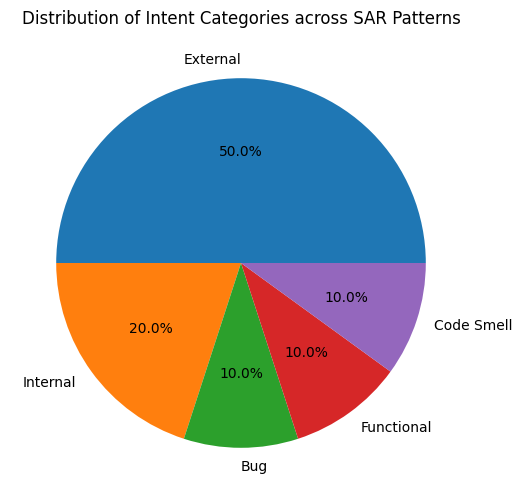

In [120]:
# Top 10 SAR Patterns with their Intent Categories
top_10_patterns = total_df_sorted.columns[1:11].tolist()
category_map = {
    'Bug': set(bug_words),
    'Internal': set(internal_words),
    'Functional': set(functional_words),
    'External': set(external_words),
    'Code Smell': set(smell_words)
}
def classify_pattern_exact(pattern, category_map):
    """
    Classifies a single SAR pattern with an exact match lookup.
    """
    # Iterate through categories and check for exact membership
    for category_name, word_set in category_map.items():
        if pattern in word_set:
            return category_name

    return 'Unknown'
intent_categories = [classify_pattern_exact(p, category_map) for p in top_10_patterns]
data = {
    'SAR Pattern': top_10_patterns,
    'Intent Category': intent_categories
}

df = pd.DataFrame(data)

# Count occurrences of each intent category
category_counts = df['Intent Category'].value_counts()
category_percentages = (category_counts / category_counts.sum() * 100).round(1)
print(category_percentages)

plt.figure(figsize=(6, 6))
plt.pie(category_counts, labels=category_counts.index, autopct='%1.1f%%')
plt.title('Distribution of Intent Categories across SAR Patterns')
plt.show()

In [126]:
# Chi-square goodness-of-fit

observed = category_percentages.to_numpy()
uniform_value = 100/len(category_map)
expected = np.full(shape=len(category_map), fill_value=uniform_value) # uniform expectation

chisq, p = chisquare(f_obs=observed, f_exp=expected)
print("Chi-square goodness-of-fit")
print("Chi-square =", chisq)
print("p-value =", p)

Chi-square goodness-of-fit
Chi-square = 60.0
p-value = 2.9008631203404573e-12


A chi-square goodness-of-fit test is used to determine whether observed categorical data matches an expected distribution.

A chi-square goodness-of-fit test revealed a significant deviation from an even distribution of intent categories, χ²(4, N=100) = 70.00, p < .0001.
This indicates that some intent categories appear far more frequently than others, suggesting non-random usage patterns in SAR documentation.

### RQ 1.3

In [134]:
# Chi-square test of independence

agent_SAR_count = percent_sar_df.drop(columns=["Total PRs", "% with SAR"]).copy()
SAR_count_df = pd.DataFrame(agent_SAR_count)

contingency = pd.crosstab(SAR_count_df["agent"], SAR_count_df["PRs with SAR"])
chi2, p, dof, expected = chi2_contingency(contingency)

print("Chi-square test of independence")
print("Chi-square:", chi2)
print("p-value:", p)
print("Degrees of freedom:", dof)

Chi-square test of independence
Chi-square: 20.000000000000004
p-value: 0.22022064660169877
Degrees of freedom: 16


A chi-square test of independence examines whether two categorical variables are related or independent of each other in the data. Here, I tested if the AI agent used and whether a SAR event occurred are independent (unrelated), across five agents and two outcomes (SAR or not).​

A chi-square test of independence found no statistically significant association between agent and SAR occurrence, χ²(16, N=2288) = 20.00, p = .220.
This suggests that SAR documentation frequency does not differ meaningfully across AI agents. There is no compelling evidence that agent choice affects SAR documentation frequency. The pattern of SAR counts is very likely to be due to random variation, not an effect of the specific agent.